In [346]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score,  KFold
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge, Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.svm import SVR
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
import pickle
import os
from scipy.stats import zscore

EDA and preprocessing

In [347]:
np.random.seed(42)
data = pd.read_csv('train.csv')
print(data.shape)
data.head(3)

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [348]:
# Drop unneeded column
data.drop('Id', axis = 1, inplace=True)

# Drop all columns with >= 50% NaN values
threshold = len(data) * 0.5
cols_to_drop = data.columns[data.isnull().sum() >= threshold]
data.drop(cols_to_drop, axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)

print("Columns missing at least 50 percent of values:\n", cols_to_drop)
print(data.shape)

Columns missing at least 50 percent of values:
 Index(['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')
(1460, 75)


Visualizing the data

C:\Users\rtesi\AppData\Local\Temp\ipykernel_14380\3796638337.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['SalePrice'], shade=True, color='red', label='SalePrice')


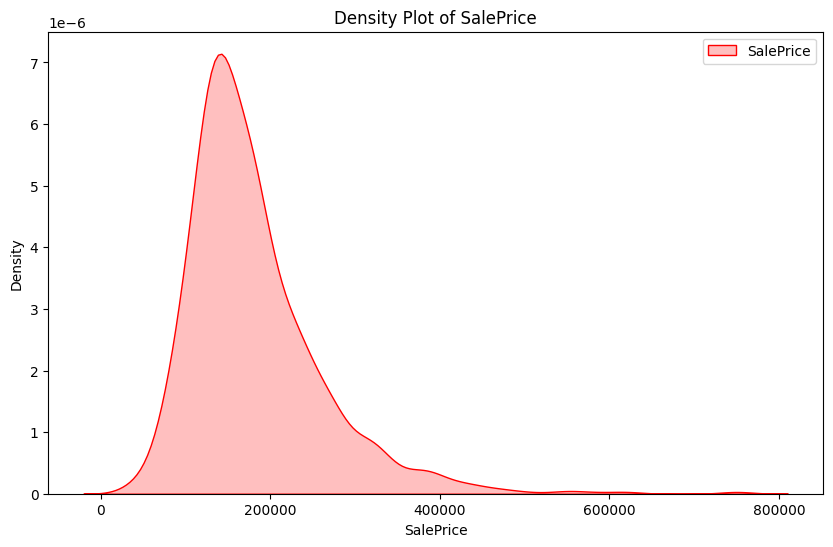

In [349]:
# Visualize distribution of target variable
plt.figure(figsize=(10, 6))
sns.kdeplot(data['SalePrice'], shade=True, color='red', label='SalePrice')
plt.title('Density Plot of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.legend()
plt.savefig('untransformed_target_density.png')
plt.show()

C:\Users\rtesi\AppData\Local\Temp\ipykernel_14380\550789266.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['SalePrice'], shade=True, color='green', label='Log(SalePrice)')


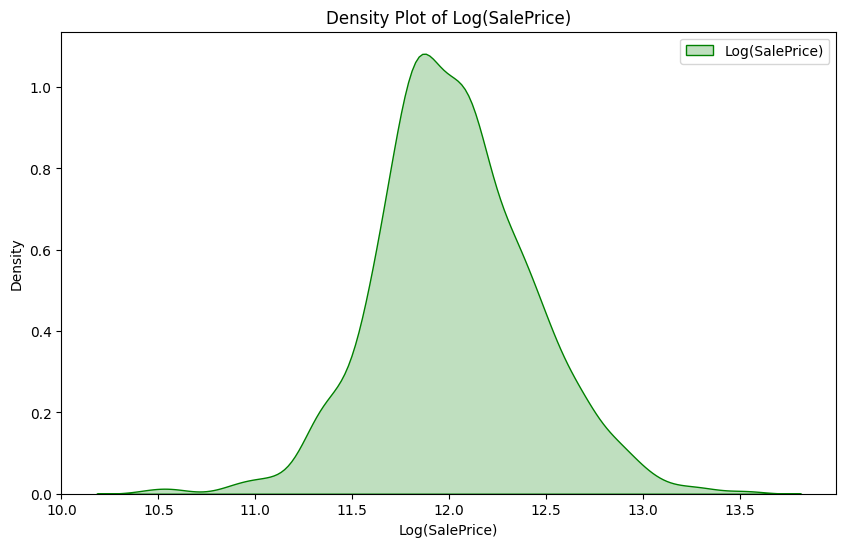

In [350]:
# Visualize distribution of log transformed target variable
data['SalePrice'] = np.log1p(data['SalePrice']) # not a form of information leakage

plt.figure(figsize=(10, 6))
sns.kdeplot(data['SalePrice'], shade=True, color='green', label='Log(SalePrice)')
plt.title('Density Plot of Log(SalePrice)')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Density')
plt.legend()
plt.savefig('transformed_target_density.png')
plt.show()

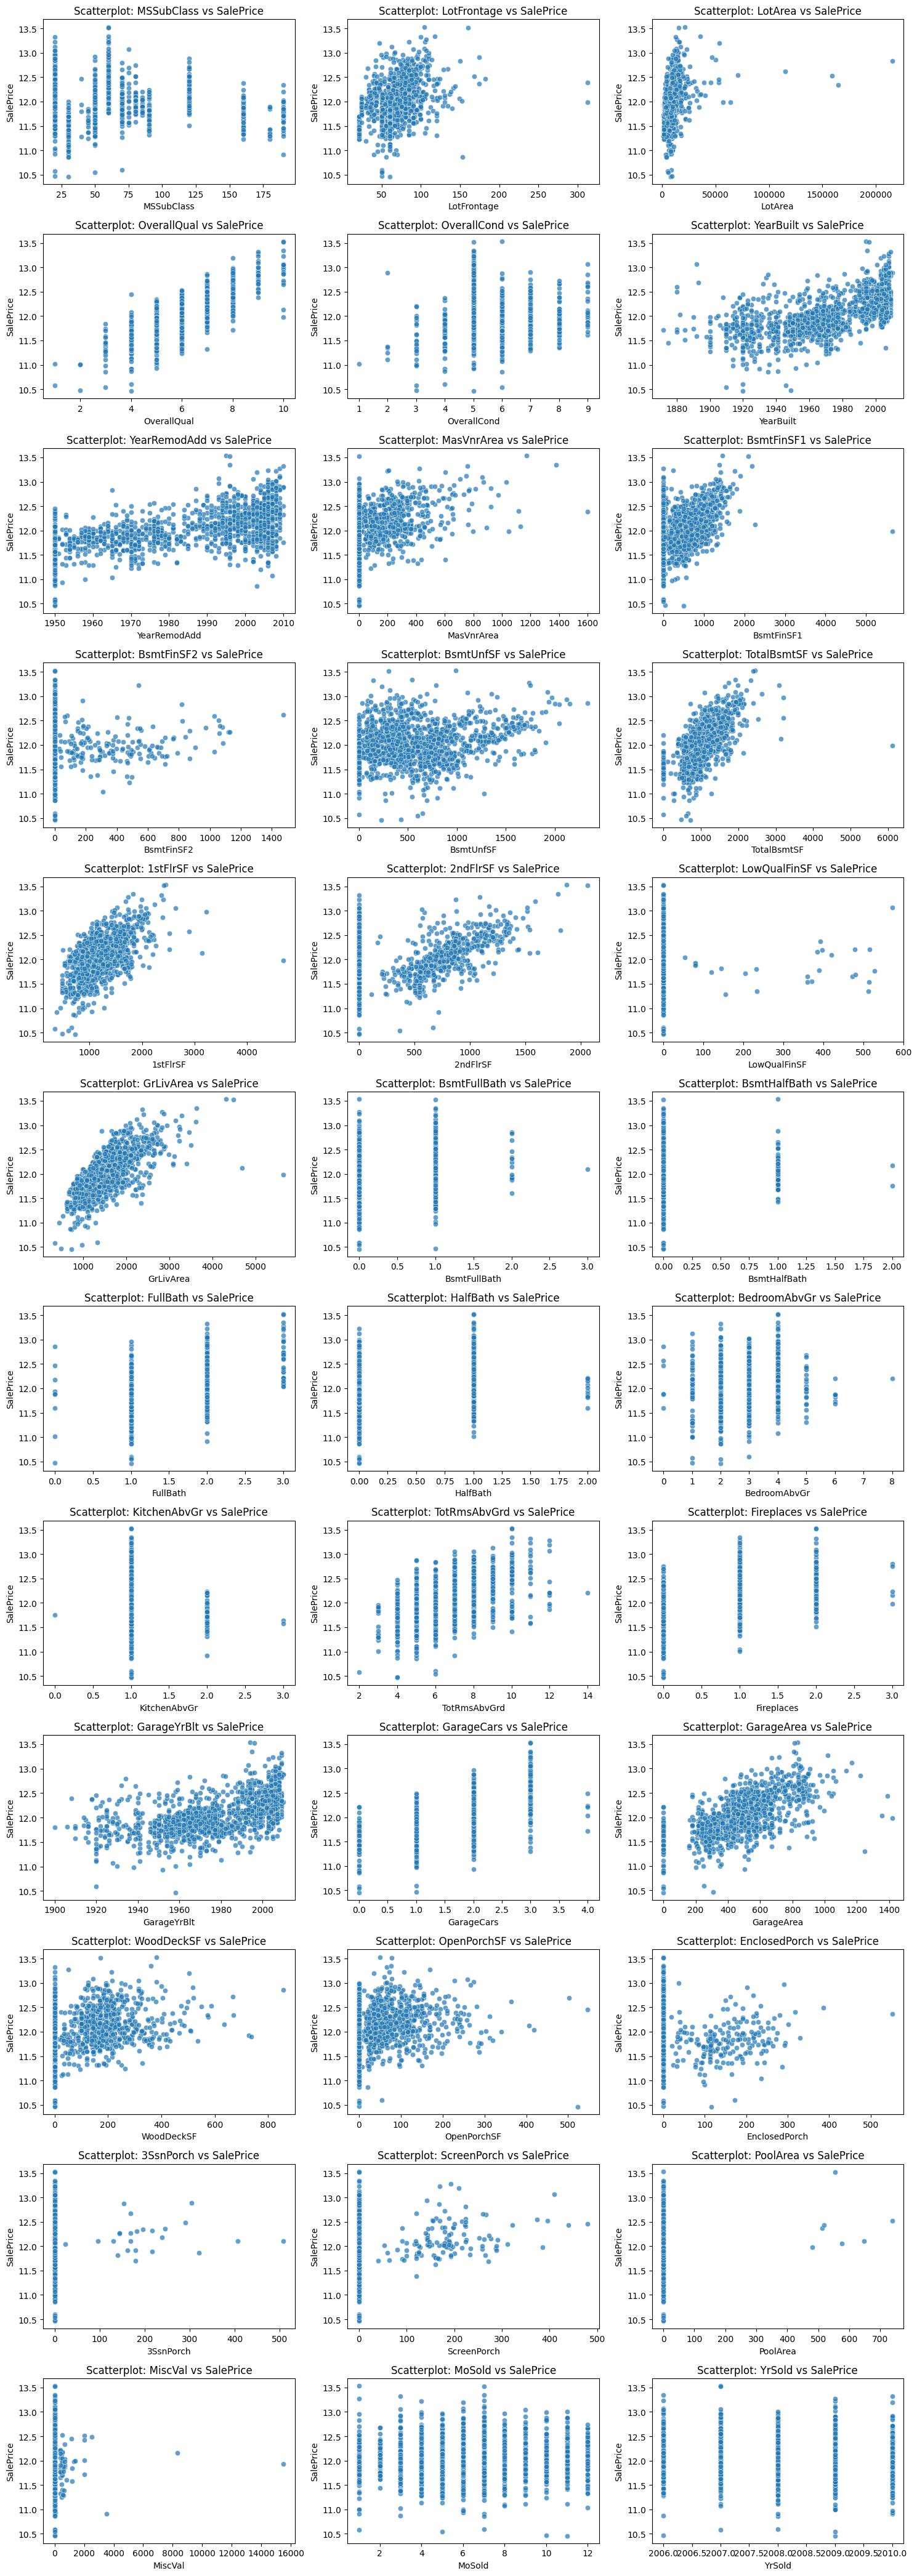

In [351]:
# Scatterplots for numeric columns
numeric_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_data = data.select_dtypes(include=numeric_types)

plt.figure(figsize=(15, 45))

# Create scatterplots for each numeric column
for i, column in enumerate(numeric_data.columns):
    if column != 'SalePrice':  # Avoid plotting SalePrice against itself
        plt.subplot((len(numeric_data.columns) - 1) // 3 + 1, 3, i + 1)  # Arrange the plots in a grid
        sns.scatterplot(x=numeric_data[column], y=numeric_data['SalePrice'], alpha=0.7)
        plt.title(f'Scatterplot: {column} vs SalePrice')
        plt.xlabel(column)
        plt.ylabel('SalePrice')

# Adjust layout for better display
plt.tight_layout()
plt.show()

Object Columns:
 Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')


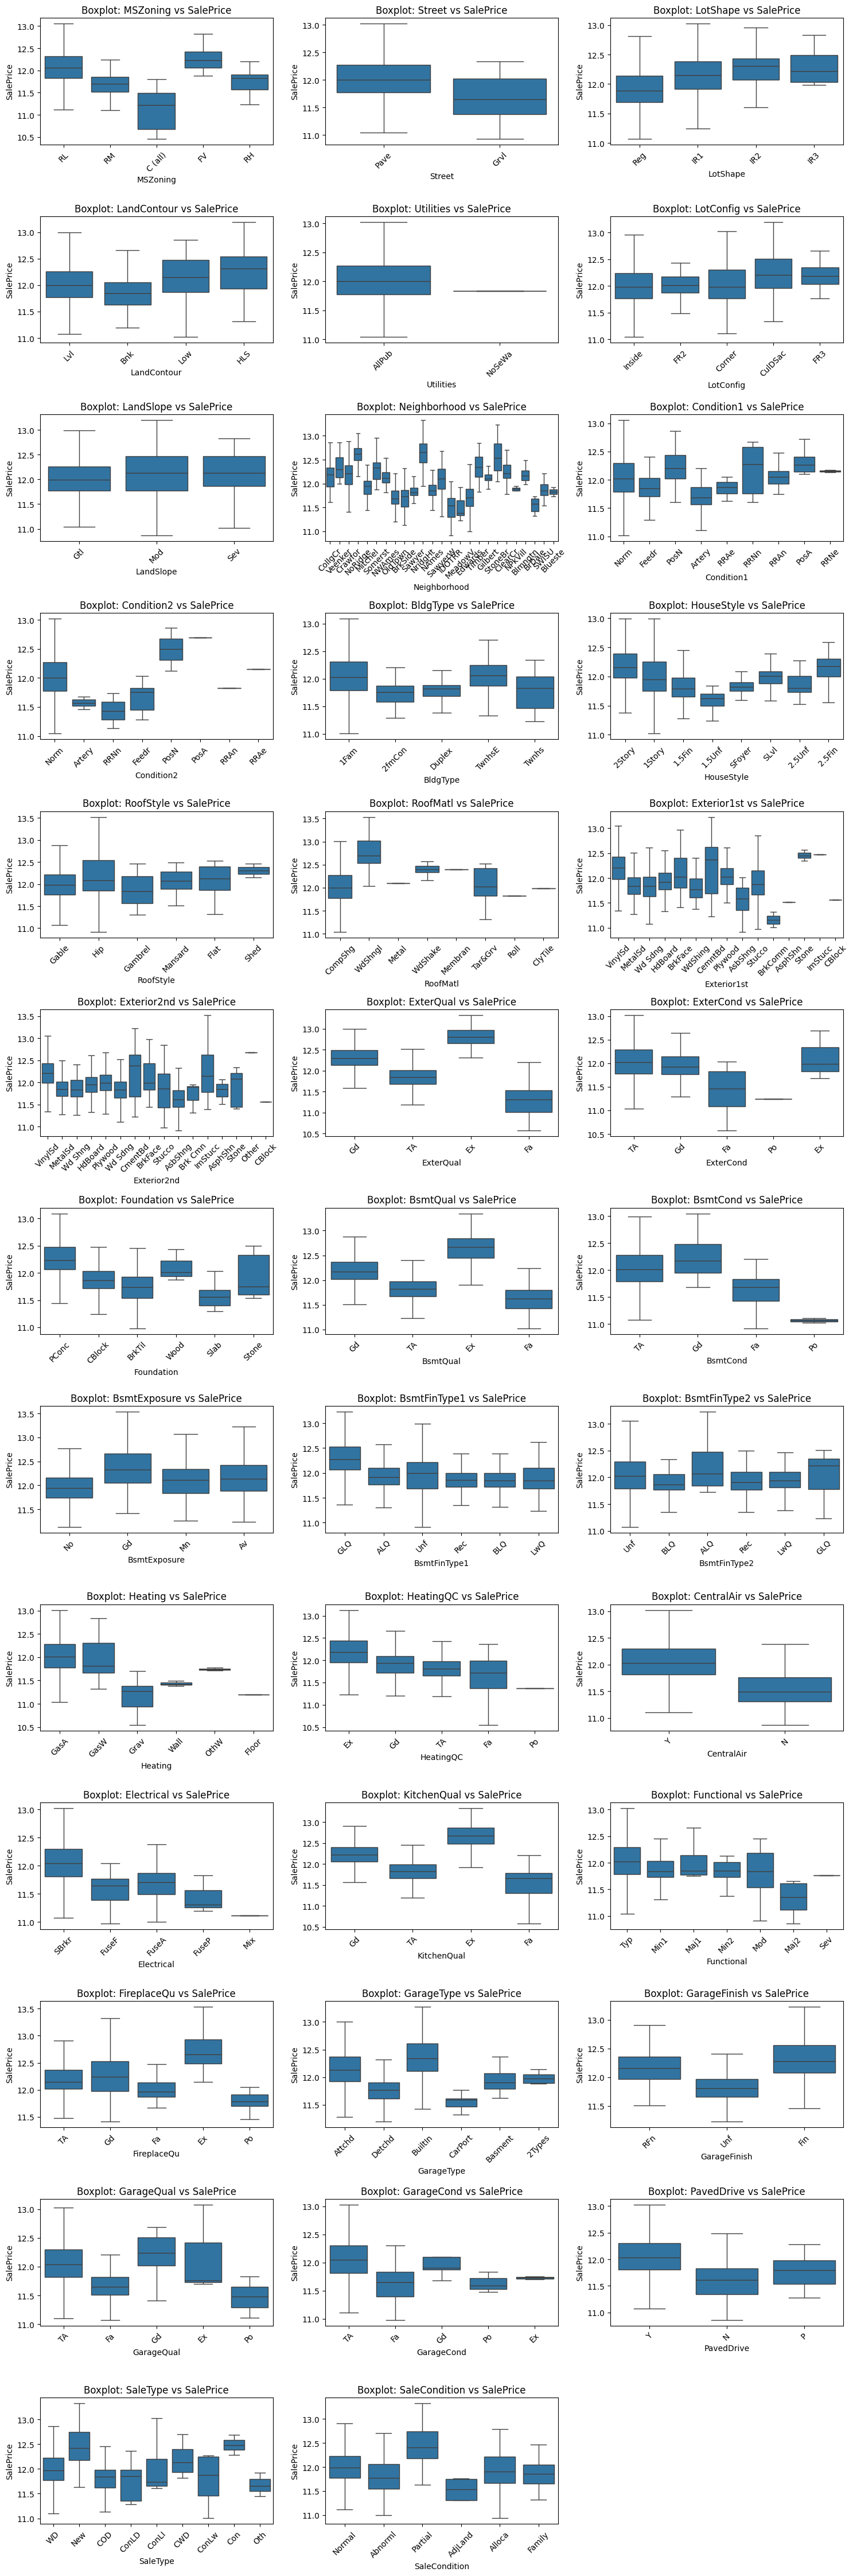

In [352]:
# Boxplots for categorical columns
categorical_data = data.select_dtypes(include=['object'])
print("Object Columns:\n", categorical_data.columns)

# Set up the figure for subplots
plt.figure(figsize=(15, 45))  # Set the figure size

# Create boxplots for each categorical column
for i, column in enumerate(categorical_data.columns):
    plt.subplot((len(categorical_data.columns) - 1) // 3 + 1, 3, i + 1)  # Arrange the plots in a grid
    sns.boxplot(x=categorical_data[column], y=data['SalePrice'], showfliers=False)
    plt.title(f'Boxplot: {column} vs SalePrice')
    plt.xlabel(column)
    plt.ylabel('SalePrice')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()

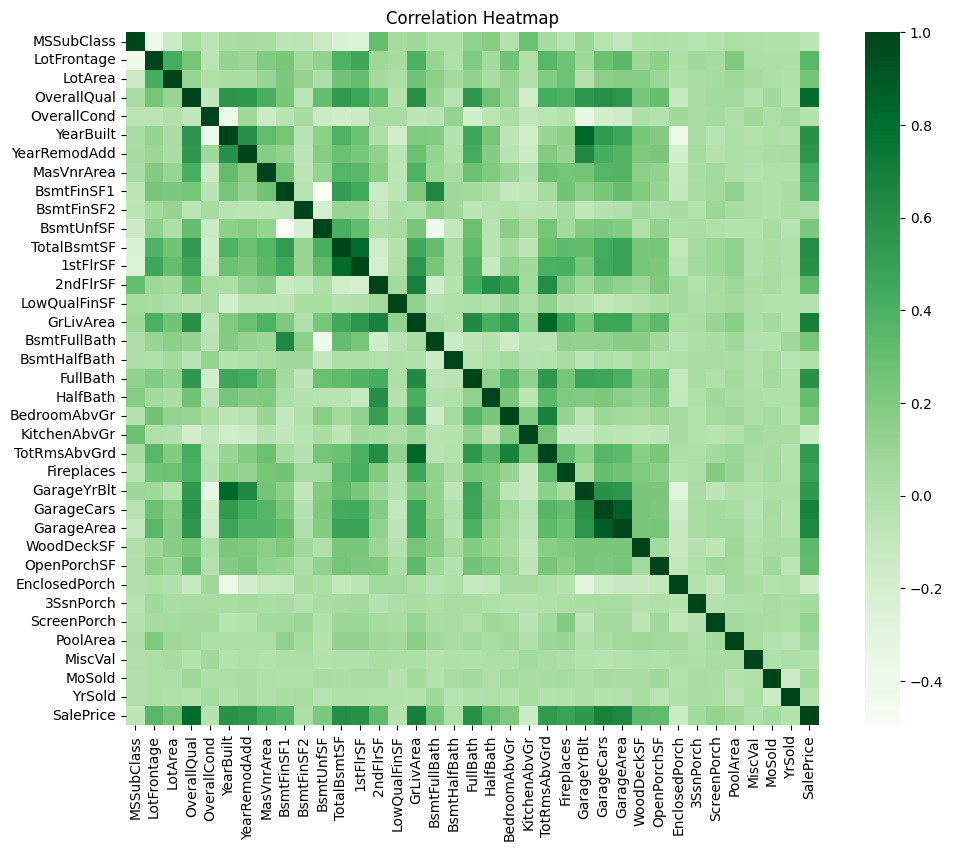

In [353]:
# Correlation matrix (heatmap) for numeric variables
cor_matrix = numeric_data.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(cor_matrix, cmap='Greens', cbar=True, square=True)
plt.title("Correlation Heatmap")
plt.show()

Impute missing data

In [354]:
# Calculate the number of missing values for each column
null_counts = data.isnull().sum()
# Get columns that have missing values
null_columns = null_counts[null_counts > 0]

# Printing the columns and their respective null value counts
print("Columns that contain missing values:")
for column, null_count in null_columns.items():
    print(f"Column: {column}, Column type: {data[column].dtype}, Null Values: {null_count}")

print("Missing values in target variables:", data['SalePrice'].isnull().sum())

data['LotFrontage'].fillna(0, inplace=True) # Assume values without a lot frontage have no boundary with a public space
data['MasVnrArea'].fillna(0, inplace=True) # Assume values without a MasVnrArea should be zero

data['BsmtQual'].fillna('None', inplace=True) 
data['BsmtCond'].fillna('None', inplace=True)
data['BsmtExposure'].fillna('None', inplace=True)
data['BsmtFinType1'].fillna('None', inplace=True)
data['BsmtFinType2'].fillna('None', inplace=True)

data['GarageType'].fillna('None', inplace=True) 
data['GarageFinish'].fillna('None', inplace=True)
data['GarageQual'].fillna('None', inplace=True)
data['GarageCond'].fillna('None', inplace=True)

# Note, we assume missing values for GarageYrBlt are because that house doesn't have a garage, 
# but there's not a way to put 'None' year while keeping the variable numeric, so we will just median impute
# But that variable will get removed anyway for having too high VIF, so it doesn't matter in the end

# Median impute for remaining numeric data
for column in numeric_data.columns:
    median_value = data[column].median()
    data[column].fillna(median_value, inplace=True)

# Mode impute for remaining categorical data
for column in categorical_data.columns:
    mode_value = data[column].mode()[0]  # Get the most frequent category
    data[column].fillna(mode_value, inplace=True)

Columns that contain missing values:
Column: LotFrontage, Column type: float64, Null Values: 259
Column: MasVnrArea, Column type: float64, Null Values: 8
Column: BsmtQual, Column type: object, Null Values: 37
Column: BsmtCond, Column type: object, Null Values: 37
Column: BsmtExposure, Column type: object, Null Values: 38
Column: BsmtFinType1, Column type: object, Null Values: 37
Column: BsmtFinType2, Column type: object, Null Values: 38
Column: Electrical, Column type: object, Null Values: 1
Column: FireplaceQu, Column type: object, Null Values: 690
Column: GarageType, Column type: object, Null Values: 81
Column: GarageYrBlt, Column type: float64, Null Values: 81
Column: GarageFinish, Column type: object, Null Values: 81
Column: GarageQual, Column type: object, Null Values: 81
Column: GarageCond, Column type: object, Null Values: 81
Missing values in target variables: 0


C:\Users\rtesi\AppData\Local\Temp\ipykernel_14380\3042140138.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['LotFrontage'].fillna(0, inplace=True) # Assume values without a lot frontage have no boundary with a public space
C:\Users\rtesi\AppData\Local\Temp\ipykernel_14380\3042140138.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate

Check for multicollinearity

In [355]:
features = data.drop(columns=['SalePrice'])
target = data['SalePrice']
numeric_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_feature_data = features.select_dtypes(include=numeric_types)

# Add a constant column to the numeric features
numeric_feature_data = add_constant(numeric_feature_data)

# Perform VIF calculation
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['Variable'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Remove collinear features recursively based on VIF
def remove_collinear_features(df, threshold=5):
    vif_data = calculate_vif(df)
    removed_features = []

    while vif_data['VIF'].max() > threshold:
        # Find the feature with the highest VIF and remove it
        max_vif_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'Variable']
        print(f"Removing feature {max_vif_feature} with VIF = {vif_data['VIF'].max()}")
        
        # Drop the feature from the dataset
        df = df.drop(columns=[max_vif_feature])
        
        removed_features.append(max_vif_feature)

        # Recalculate VIF after removal
        vif_data = calculate_vif(df)
    
    return df, removed_features

# Remove collinear features from numeric_feature_data
data_no_multicollinearity, features_removed_through_VIF = remove_collinear_features(numeric_feature_data, threshold=5)
print("Number of collinear features removed:", len(features_removed_through_VIF))

c:\Users\rtesi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing feature BsmtFinSF1 with VIF = inf
Removing feature 1stFlrSF with VIF = inf


c:\Users\rtesi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing feature const with VIF = 2414068.7334908964
Removing feature YrSold with VIF = 24052.15526089326
Removing feature GarageYrBlt with VIF = 20460.42881056544
Removing feature YearRemodAdd with VIF = 13631.747290120813
Removing feature YearBuilt with VIF = 111.42655480790681
Removing feature GrLivArea with VIF = 98.92497231461286
Removing feature TotRmsAbvGrd with VIF = 67.59948046355728
Removing feature OverallQual with VIF = 48.08760361816149
Removing feature GarageCars with VIF = 34.36942866719497
Removing feature KitchenAbvGr with VIF = 24.412752250217515
Removing feature TotalBsmtSF with VIF = 22.023942325335682
Removing feature BedroomAbvGr with VIF = 17.965413324538343
Removing feature FullBath with VIF = 14.263097827681827
Removing feature OverallCond with VIF = 10.58828598663625
Removing feature GarageArea with VIF = 7.600090235353732
Number of collinear features removed: 17


Dummy encoding

In [356]:
# Perform dummy encoding
features_removed_through_VIF.remove('const')
data_post_multicollinearity_removal = data.drop(features_removed_through_VIF, axis=1)

# Save columns that outlier removal will be performed on
numeric_features_for_outlier_removal = data_post_multicollinearity_removal.select_dtypes(include=[np.number]).columns.tolist()
numeric_features_for_outlier_removal.remove('SalePrice')

categorical_data_columns_post_multicollinearity_removal = data_post_multicollinearity_removal.select_dtypes(include=['object']).columns
data_dummied = pd.get_dummies(data_post_multicollinearity_removal, columns=categorical_data_columns_post_multicollinearity_removal, drop_first=True)
data_dummied.reset_index(drop=True, inplace=True)
# dummied_new_columns = data_dummied.columns.difference(data_post_multicollinearity_removal.columns).tolist()

X = data_dummied.drop(columns='SalePrice', axis=1)
X.reset_index(drop=True, inplace=True)

y = data_dummied['SalePrice']

Split, scale, and transform data

We will use the train data set as provided by Kaggle as our main data, and use the test set provided by Kaggle as a validation set to generate submission results

In [357]:
# Split the data into training and test sets
X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Determine which features need to be log transformed, based on which have an absolute skew of over 0.5
def determine_transformations(df, threshold=0.5):
    features_to_log_transform = []
    
    for col in numeric_features_for_outlier_removal:
        if pd.api.types.is_numeric_dtype(df[col]):
            skewness = df[col].skew()
            if abs(skewness) > threshold:
                features_to_log_transform.append(col)
    
    return features_to_log_transform

features_to_log_transform = determine_transformations(X_train_)
print("Features that need to be log transformed:", features_to_log_transform)

# Apply log transformation to appropriate features
X_train_[features_to_log_transform] = X_train_[features_to_log_transform].apply(lambda x: np.log1p(x))
X_test_[features_to_log_transform] = X_test_[features_to_log_transform].apply(lambda x: np.log1p(x))

# Normalize train and test sets independently (scaling all features)
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_)
X_test_normalized = scaler.transform(X_test_)

X_train = pd.DataFrame(X_train_normalized, columns=X_train_.columns)
X_test = pd.DataFrame(X_test_normalized, columns=X_test_.columns)

Features that need to be log transformed: ['MSSubClass', 'LotArea', 'MasVnrArea', 'BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


Outlier removal

In [358]:
# Remove outliers from original numeric columns on the train set

def remove_outliers_based_on_target(X_train, y_train, threshold=2):
    # Ensure y_train is a pandas Series with the same index as X_train
    y_train = y_train.reset_index(drop=True)

    # Compute Z-scores for the target variable (y_train)
    z_scores = np.abs(zscore(y_train))  # Absolute value of Z-scores
    
    # Identify outliers: Rows where the Z-score exceeds the threshold
    outliers = z_scores > threshold
    
    # Remove rows from both X_train and y_train where the target is an outlier
    X_train_cleaned = X_train[~outliers]
    y_train_cleaned = y_train[~outliers]
    
    return X_train_cleaned, y_train_cleaned

print("Sample number before removing outliers:", y_train.shape[0])
X_train, y_train = remove_outliers_based_on_target(X_train, y_train, threshold=3)

# X_train.reset_index(drop=True, inplace=True)
# y_train.reset_index(drop=True, inplace=True)

print("Sample number after removing outliers:", y_train.shape[0])
y_train.reset_index(drop=True, inplace=True)


Sample number before removing outliers: 1168
Sample number after removing outliers: 1160


Evaluation functions

Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

In [359]:
# For final test evaluation
def rmse_log(true_y, predicted_y):
    return np.sqrt(mean_squared_error(true_y, predicted_y))

# For evaluating CV scores during training
def cv_rmse(model, training_features, training_target):
    rmse = np.sqrt(-cross_val_score(model, training_features, training_target, scoring="neg_mean_squared_error", cv=5))
    return (rmse)

In [ ]:
# Prep parameter grid for gridsearch on models in the pipeline
param_grids = {
    'lasso': {
        # 'model__alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100],
        # 'model__max_iter': [1000, 100000, 10000000],
        # 'model__tol': [1e-4, 1e-3, 1e-2]
        'model__alpha': [0.001], 'model__max_iter': [1000], 'model__tol': [0.01]

    },
    'ridge': {
        # 'model__alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100],
        # 'model__max_iter': [1000, 5000, 10000],
        # 'model__tol': [1e-4, 1e-3, 1e-2],
        # 'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
        'model__alpha': [100], 'model__max_iter': [1000], 'model__solver': ['sparse_cg'], 'model__tol': [0.0001]
    },
    'xgboost': {
        # 'model__n_estimators': [50, 100, 200],
        # 'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
        # 'model__max_depth': [3, 5, 7, 10],
        # 'model__subsample': [0.6, 0.8, 1.0],
        # 'model__colsample_bytree': [0.6, 0.8, 1.0],
        # 'model__gamma': [0, 1, 5],
        # 'model__reg_alpha': [0, 0.1, 1],
        # 'model__reg_lambda': [0.1, 1, 10]
        'model__colsample_bytree': [0.6], 'model__gamma': [0], 'model__learning_rate': [0.05], 'model__max_depth': [5], 'model__n_estimators': [200], 'model__reg_alpha': [0.1], 'model__reg_lambda': [0.1], 'model__subsample': [0.6]
    },
    # 'lightgbm' : {
    #     # 'model__n_estimators': [50, 100, 200],
    #     # 'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    #     # 'model__max_depth': [-1, 3, 5, 7],
    #     # 'model__num_leaves': [31, 50, 100],
    #     # 'model__subsample': [0.6, 0.8, 1.0],
    #     # 'model__colsample_bytree': [0.6, 0.8, 1.0],
    #     # 'model__reg_alpha': [0, 0.1, 1],
    #     # 'model__reg_lambda': [0.1, 1, 10]
    #     'model__n_estimators': [5000], 'model__learning_rate': [0.01], 'model__num_leaves': [4], 
    #     'model__max_bin': [200], 'model__bagging_fraction': [0.75], 'model__bagging_freq': [5],
    #     'model__feature_fraction': [0.2], 'model__verbose': [-1]
    # },
    'svr' : {
        # 'model__C': [0.1, 1, 10, 100],
        # 'model__epsilon': [0.01, 0.1, 0.2, 0.5],
        # 'model__kernel': ['linear', 'poly', 'rbf']
        'model__C': [0.1], 'model__epsilon': [0.1], 'model__kernel': ['linear']
    },
    'gbr' : {
        # 'model__n_estimators':[3000], 'model__learning_rate':[0.05],
        # 'model__max_depth':[4], 'model__max_features':['sqrt'],
        # 'model__min_samples_leaf':[15], 'model__min_samples_split':[10],
        # 'model__loss':['huber']
        'model__learning_rate': [0.05], 'model__loss': ['huber'], 'model__max_depth': [4], 'model__max_features': ['sqrt'], 'model__min_samples_leaf': [15], 'model__min_samples_split': [10], 'model__n_estimators': [3000]
    },
}

# Pipeline with 6 models
models = {
    'lasso': Pipeline([
        ('scaler', RobustScaler()),
        ('model', Lasso(random_state=42))
    ]),
    'ridge': Pipeline([
        ('scaler', RobustScaler()),  
        ('model', Ridge(random_state=42))
    ]),
    'xgboost': Pipeline([
        ('model', XGBRegressor(random_state=42))
    ]),
    'svr': Pipeline([  # Added Support Vector Regressor (SVR)
        ('scaler', RobustScaler()),
        ('model', SVR())
    ]),
    # 'lightgbm': Pipeline([  # Fixed to use LGBMRegressor for LightGBM
    #     ('model', lgb.LGBMRegressor(random_state=42))
    # ]),
    'gbr': Pipeline([
        ('scaler', RobustScaler()),
        ('model', GradientBoostingRegressor(random_state=42))
    ])
}

best_models = {}

for model, pipeline in models.items():
    print(f"Grid search started for {model}")

    # Find the best hyperparameters for the model
    grid = GridSearchCV(estimator=pipeline, param_grid=param_grids[model], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[model] = grid.best_estimator_

    # Print metrics
    print(f"Best {model} params: {grid.best_params_}\n")
    # print(f"Best cross-validation MSE score: {-grid.best_score_}")

# Gather the best models for stacking
lasso = best_models['lasso']
ridge = best_models['ridge']
xgb = best_models['xgboost']
# lightgbm = best_models['lightgbm']
svr = best_models['svr']
gbr = best_models['gbr']

# Stacking
stack_gen = StackingRegressor(
    estimators=[
        ('lasso', best_models['lasso']),        # Lasso model from grid search
        ('ridge', best_models['ridge']),        # Ridge model from grid search
        ('svr', best_models['svr']),            # Support Vector Regressor
        ('xgboost', best_models['xgboost']),    # XGBoost model from grid search
        # ('lightgbm', best_models['lightgbm']),   # LightGBM model from grid search
        ('gbr', best_models['gbr'])
    ],
    # final_estimator=Ridge(random_state=42),  # Lasso as the final estimator
    final_estimator=XGBRegressor(random_state=42),  # Lasso as the final estimator
    cv=5,
)

scores = {}
regressors = {
                "Lasso": lasso, 
                "Ridge": ridge,
                "XGB_Regressor": xgb, 
                # "Light_gbm:": lightgbm,
                "Svr": svr,
                "Gbr":gbr,
             }

model_names = []
mean_rmse = []
std_rmse = []

# Stacking metrics
print("\nMetrics for stacking regressor:")
stack_gen.fit(X_train, y_train)

predictions = stack_gen.predict(X_test)
score = cv_rmse(stack_gen, X_train, y_train)  # Array of cross-validated RMSE scores
print(f"Stacking training mean RMSE from 5 fold CV: {score.mean():.4f} ({score.std():.4f})")
scores['Stacking'] = (score.mean(), score.std())

log_rmse_stacked = rmse_log(true_y=y_test, predicted_y=predictions)  # Array of cross-validated RMSE scores testing
print(f"Stacking testing mean RMSE from 5 fold CV: {log_rmse_stacked.mean():.4f} ({log_rmse_stacked.std():.4f})")

# Individual model metrics
print("Metrics for individual regressor:")
for name, regressor in regressors.items():
    predictions = regressor.predict(X_test)

    score = cv_rmse(regressor, X_train, y_train)  # Array of cross-validated RMSE scores
    print(f"{name} training mean RMSE from 5 fold CV: {score.mean():.4f} ({score.std():.4f})")
    scores[name] = (score.mean(), score.std())

    log_rmse = rmse_log(true_y=y_test, predicted_y=predictions)  # Array of cross-validated RMSE scores testing
    print(f"{name} testing mean RMSE from 5 fold CV: {log_rmse.mean():.4f} ({log_rmse.std():.4f})\n")

    model_names.append(name)
    mean_rmse.append(log_rmse.mean())
    std_rmse.append(log_rmse.std())

model_names.append("Stacking")
mean_rmse.append(log_rmse_stacked.mean())
std_rmse.append(log_rmse_stacked.std())

Grid search started for lasso
Best lasso params: {'model__alpha': 0.001, 'model__max_iter': 1000, 'model__tol': 0.01}

Grid search started for ridge
Best ridge params: {'model__alpha': 100, 'model__max_iter': 1000, 'model__solver': 'sparse_cg', 'model__tol': 0.0001}

Grid search started for xgboost
Best xgboost params: {'model__colsample_bytree': 0.6, 'model__gamma': 0, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__reg_alpha': 0.1, 'model__reg_lambda': 0.1, 'model__subsample': 0.6}

Grid search started for svr
Best svr params: {'model__C': 0.1, 'model__epsilon': 0.1, 'model__kernel': 'linear'}

Grid search started for gbr
Best gbr params: {'model__learning_rate': 0.05, 'model__loss': 'huber', 'model__max_depth': 4, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__min_samples_split': 10, 'model__n_estimators': 3000}


Metrics for stacking regressor:


Plotting results

C:\Users\rtesi\AppData\Local\Temp\ipykernel_14380\1163687302.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(model_names, mean_rmse, yerr=std_rmse, fmt='o', color='b', capsize=5, linestyle='-', marker='o')


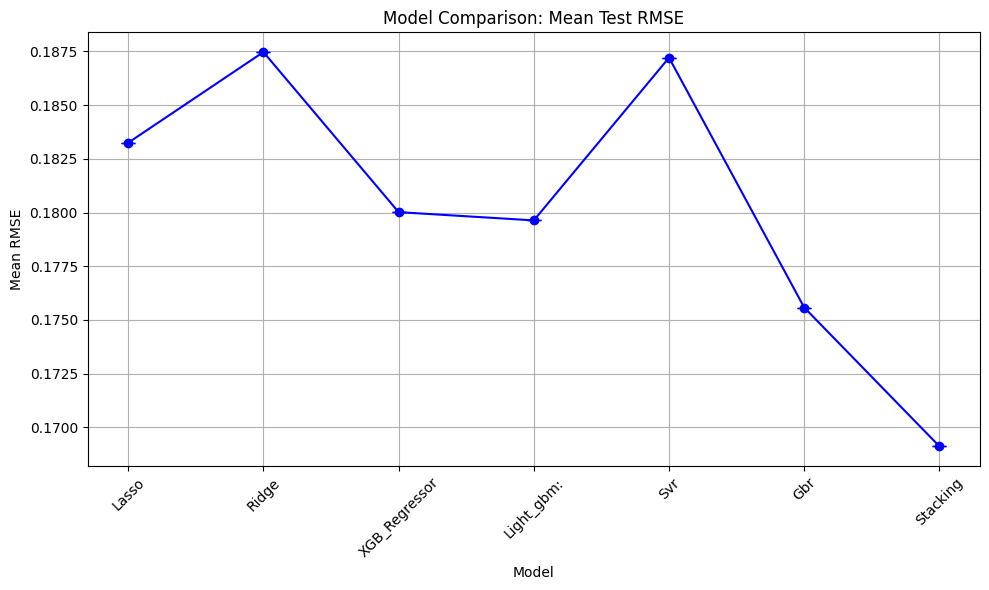

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.errorbar(model_names, mean_rmse, yerr=std_rmse, fmt='o', color='b', capsize=5, linestyle='-', marker='o')
plt.title('Model Comparison: Mean Test RMSE')
plt.xlabel('Model')
plt.ylabel('Mean RMSE')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('final_results_plot.png')
plt.show()

Blending

In [ ]:
def blended_predictions(new_data):
    return ((0.12 * lasso.predict(new_data)) + \
            (0.12 * ridge.predict(new_data)) + \
            (0.12 * xgb.predict(new_data)) + \
            (0.12 * svr.predict(new_data)) + \
            (0.12 * gbr.predict(new_data)) + \
            (0.4 * stack_gen.predict(np.array(new_data))))

# On all the data we used for training/testing
blended_score = rmse_log(y_test, blended_predictions(X_test))
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.16437782351740832


c:\Users\rtesi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
c:\Users\rtesi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
c:\Users\rtesi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
c:\Users\rtesi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Pickle the model for future use

In [ ]:
# Save the trained model using pickle
model_filename = 'stacked_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(stack_gen, f)

# Check if the file exists in the working directory
if os.path.exists(model_filename):
    print(f"Model has been pickled and saved as '{model_filename}'")
else:
    print(f"Failed to save '{model_filename}'")

Model has been pickled and saved as 'stacked_model.pkl'


Prep Kaggle Submission

In [ ]:
new_data = pd.read_csv("test.csv")
id_column = new_data['Id']

# Drop features removed through VIF and other columns to be dropped
new_data.drop(features_removed_through_VIF, axis=1, inplace=True)
new_data.drop(cols_to_drop, axis=1, inplace=True)

# Separate numeric and categorical columns
numeric_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_data = new_data.select_dtypes(include=numeric_types)
categorical_data = new_data.select_dtypes(include=['object'])

# Median impute for numeric data
for column in numeric_data.columns:
    median_value = new_data[column].median()
    new_data[column].fillna(median_value, inplace=True)

# Mode impute for categorical data
for column in categorical_data.columns:
    mode_value = new_data[column].mode()[0]  # Get the most frequent category
    new_data[column].fillna(mode_value, inplace=True)

# Apply one-hot encoding for categorical columns
for_dummy = new_data.select_dtypes(include=['object']).columns
data_dummied = pd.get_dummies(new_data, columns=for_dummy, drop_first=True)

# Reset the index after transformations
data_dummied.reset_index(drop=True, inplace=True)
new_data = data_dummied

# Log transform the features that were tranformed during training
new_data[features_to_log_transform] = new_data[features_to_log_transform].apply(lambda x: np.log1p(x))

# Standardize the data
new_data.drop('Id', inplace=True, axis=1)
scaler2 = StandardScaler()
new_data = pd.DataFrame(scaler2.fit_transform(new_data), columns = new_data.columns)

# Ensure that new_data and X_test have the same columns before prediction
df1_columns = set(new_data.columns)
df2_columns = set(X_test.columns)

# Find columns in X_test that are not in new_data
missing_in_new_data = df2_columns - df1_columns

# Add missing columns in new_data with 0 values
for col in missing_in_new_data:
    new_data[col] = 0

# Ensure columns of new_data match the order of X_test columns
new_data = new_data[X_test.columns]

# Predict using the stacked model
predictions = stack_gen.predict(new_data)
exponentiated_predictions = np.exp(predictions)

# Prepare the results for saving to CSV
results = pd.DataFrame({
    'Id': id_column,
    'SalePrice': exponentiated_predictions 
})

# Save results to a new CSV file
results.to_csv('stacked_model_predictions.csv', index=False)

C:\Users\rtesi\AppData\Local\Temp\ipykernel_14380\978513350.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_data[column].fillna(median_value, inplace=True)
C:\Users\rtesi\AppData\Local\Temp\ipykernel_14380\978513350.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 